# Supervised Pipeline

## SVM

VIF Results After Dropping Features:
                 feature       VIF
0  ACTUALTERMTOMATURITY  1.903104
1                COUPON  4.074414
2   ADDITIONALPURCHASED  1.123887
3          TOTALFUNDING  3.360638
4            COVERRATIO  3.693616
5      GROSSCUTOFFYIELD  4.639008
Accuracy: 0.8160621761658031
Precision: 0.8192526016360213
Recall: 0.6620208527105078
F1 Score: 0.8052188751148128


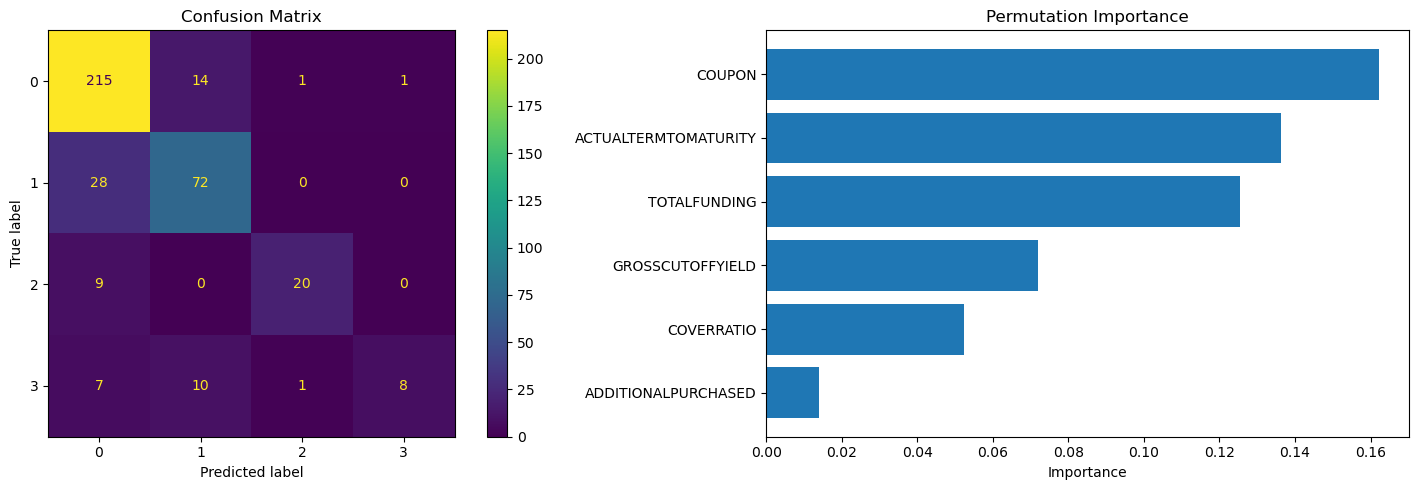

In [449]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to calculate VIF and cleaning
def vif(df):
    max_val = float('inf')
    while max_val > 5:
        vif_data = pd.DataFrame()
        X = df.select_dtypes(include=['float64', 'int64'])
        vif_data["feature"] = X.columns

        # calculating VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                           for i in range(len(X.columns))]
        max_val = max(vif_data["VIF"])
        for index, item in enumerate(vif_data['VIF']):
            if item >= max_val and max_val > 5:
                df = df.drop(vif_data.iloc[index, 0], axis=1)
    return df, vif_data

# Load dataset
df = pd.read_csv('file.csv', encoding='windows-1255')

# Remove date columns
date_columns = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).columns.str.contains('date', case=False, na=False)]
df = df.drop(columns=date_columns)

# Replace values in 'BONDS'
replacements = {
    'ממשלתית': 'GOV',
    'ממשלתית בריבית משתנה': 'GOV_VAR',
    'ממשלתית צמודה': 'GOV_INDEX',
    'ממשלתית קצרה': 'GOV_SHORT'
}
df['BONDS'] = df['BONDS'].map(replacements)

# Separate features and target for VIF calculation
df_features = df.drop(columns=['BONDS'])

# Calculate VIF and update features
df_features, vif_result = vif(df_features)
print("VIF Results After Dropping Features:\n", vif_result)

# Add the target column back to the dataset
df_scaled = pd.concat([df_features, df[['BONDS']]], axis=1)

# Separate features and target for modeling
X = df_scaled.drop(columns=['BONDS'])
y = df_scaled['BONDS']

# Define preprocessing for numerical and categorical data
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the model
clf = svm.SVC(kernel='rbf')

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))

print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Permutation Importance
perm_importance = permutation_importance(pipeline, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], cmap='viridis')
ax[0].set_title("Confusion Matrix")

ax[1].barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax[1].set_title("Permutation Importance")
ax[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

## xgboost

VIF Results After Dropping Features:
                 feature       VIF
0  ACTUALTERMTOMATURITY  1.903104
1                COUPON  4.074414
2   ADDITIONALPURCHASED  1.123887
3          TOTALFUNDING  3.360638
4            COVERRATIO  3.693616
5      GROSSCUTOFFYIELD  4.639008
Label Mapping: {'GOV': 0, 'GOV_INDEX': 1, 'GOV_SHORT': 2, 'GOV_VAR': 3}
Accuracy: 0.9896373056994818
Precision: 0.9898136919854481
Recall: 0.9686538461538462
F1 Score: 0.9894373525504309


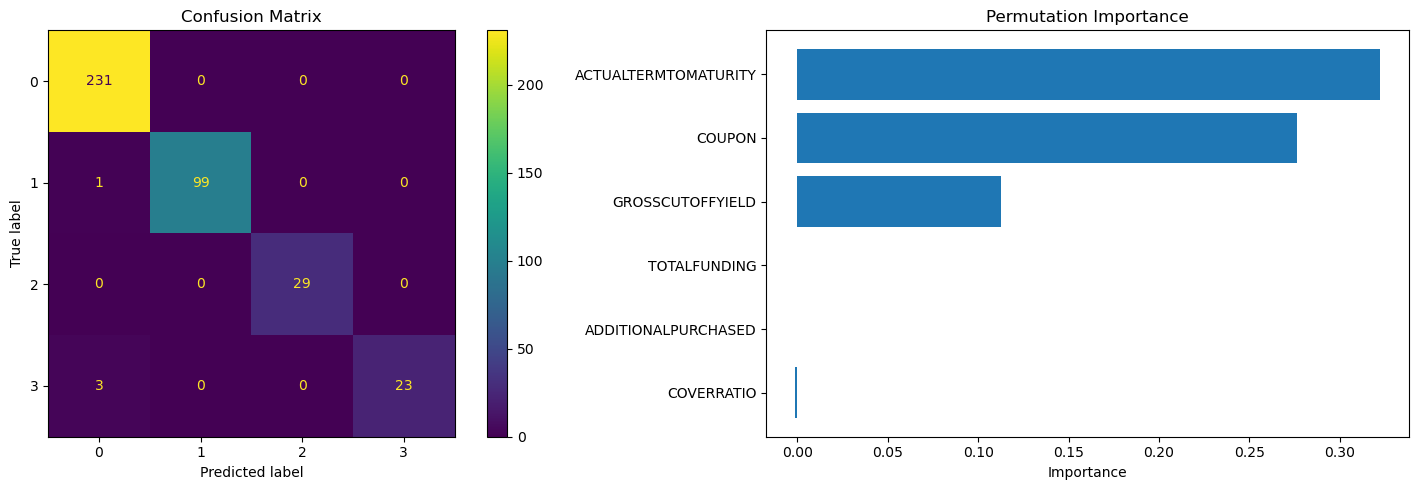

In [451]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to calculate VIF and clean features
def vif(df):
    max_val = float('inf')
    while max_val > 5:
        vif_data = pd.DataFrame()
        X = df.select_dtypes(include=['float64', 'int64'])
        vif_data["feature"] = X.columns

        # Calculate VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                           for i in range(len(X.columns))]
        max_val = max(vif_data["VIF"])
        for index, item in enumerate(vif_data['VIF']):
            if item >= max_val and max_val > 5:
                df = df.drop(vif_data.iloc[index, 0], axis=1)
    return df, vif_data

# Load dataset
df = pd.read_csv('file.csv', encoding='windows-1255')

# Remove date columns
date_columns = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).columns.str.contains('date', case=False, na=False)]
df = df.drop(columns=date_columns)

# Map BONDS column
replacements = {
    'ממשלתית': 'GOV',
    'ממשלתית בריבית משתנה': 'GOV_VAR',
    'ממשלתית צמודה': 'GOV_INDEX',
    'ממשלתית קצרה': 'GOV_SHORT'
}
df['BONDS'] = df['BONDS'].map(replacements)

# Separate features and target for VIF calculation
df_features = df.drop(columns=['BONDS'])

# Calculate VIF and update features
df_features, vif_result = vif(df_features)
print("VIF Results After Dropping Features:\n", vif_result)

# Add the target column back to the dataset
df_scaled = pd.concat([df_features, df[['BONDS']]], axis=1)

# Separate features and target for modeling
X = df_scaled.drop(columns=['BONDS'])
y = df_scaled['BONDS']

# Convert y to numeric using LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Print label mapping
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label Mapping:", label_mapping)

# Define preprocessing for numerical and categorical data
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the model
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),       # Preprocessing step
    ('classifier', xgb_model)             # Classification model
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Model evaluation
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Permutation Importance
perm_importance = permutation_importance(pipeline, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], cmap='viridis')
ax[0].set_title("Confusion Matrix")

ax[1].barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax[1].set_title("Permutation Importance")
ax[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()


## RF

VIF Results After Dropping Features:
                 feature       VIF
0  ACTUALTERMTOMATURITY  1.903104
1                COUPON  4.074414
2   ADDITIONALPURCHASED  1.123887
3          TOTALFUNDING  3.360638
4            COVERRATIO  3.693616
5      GROSSCUTOFFYIELD  4.639008
Accuracy: 0.9948186528497409
Precision: 0.9948631279325757
Recall: 0.995
F1 Score: 0.9948036511262347


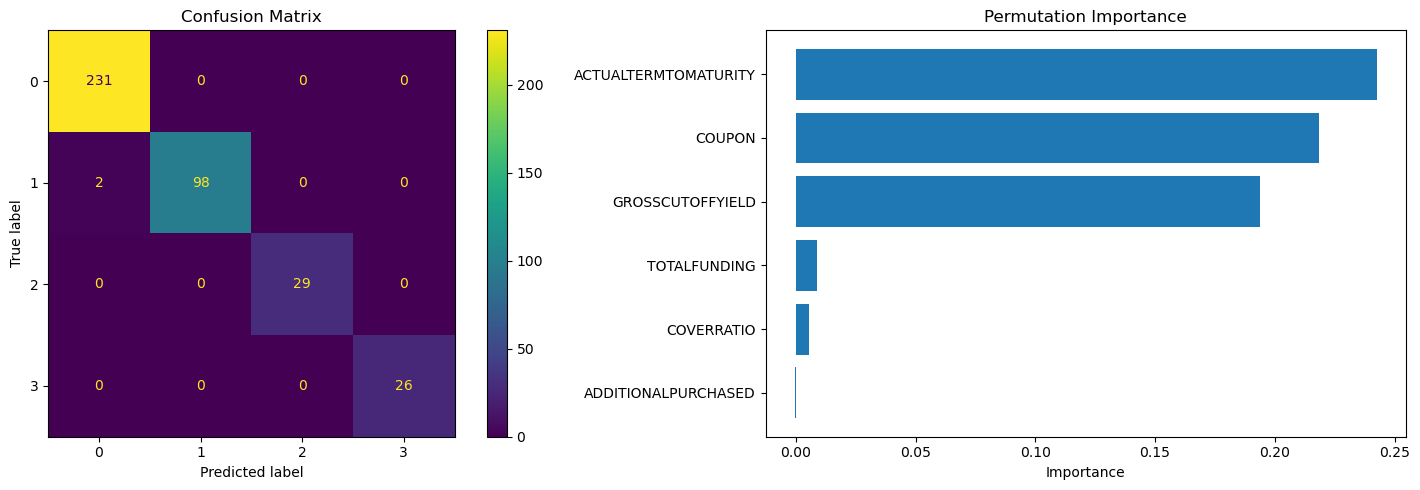

In [453]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to calculate VIF and cleaning
def vif(df):
    max_val = float('inf')
    while max_val > 5:
        vif_data = pd.DataFrame()
        X = df.select_dtypes(include=['float64', 'int64'])
        vif_data["feature"] = X.columns

        # calculating VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                           for i in range(len(X.columns))]
        max_val = max(vif_data["VIF"])
        for index, item in enumerate(vif_data['VIF']):
            if item >= max_val and max_val > 5:
                df = df.drop(vif_data.iloc[index, 0], axis=1)
    return df, vif_data

# Load dataset
df = pd.read_csv('file.csv', encoding='windows-1255')

# Remove date columns
date_columns = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).columns.str.contains('date', case=False, na=False)]
df = df.drop(columns=date_columns)

# Replace values in 'BONDS'
replacements = {
    'ממשלתית': 'GOV',
    'ממשלתית בריבית משתנה': 'GOV_VAR',
    'ממשלתית צמודה': 'GOV_INDEX',
    'ממשלתית קצרה': 'GOV_SHORT'
}
df['BONDS'] = df['BONDS'].map(replacements)

# Separate features and target for VIF calculation
df_features = df.drop(columns=['BONDS'])

# Calculate VIF and update features
df_features, vif_result = vif(df_features)
print("VIF Results After Dropping Features:\n", vif_result)

# Add the target column back to the dataset
df_scaled = pd.concat([df_features, df[['BONDS']]], axis=1)

# Separate features and target for modeling
X = df_scaled.drop(columns=['BONDS'])
y = df_scaled['BONDS']

# Define preprocessing for numerical and categorical data
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the model
rf = RandomForestClassifier()

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))

print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Permutation Importance
perm_importance = permutation_importance(pipeline, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], cmap='viridis')
ax[0].set_title("Confusion Matrix")

ax[1].barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax[1].set_title("Permutation Importance")
ax[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

## KNN

VIF Results After Dropping Features:
                 feature       VIF
0  ACTUALTERMTOMATURITY  1.903104
1                COUPON  4.074414
2   ADDITIONALPURCHASED  1.123887
3          TOTALFUNDING  3.360638
4            COVERRATIO  3.693616
5      GROSSCUTOFFYIELD  4.639008
Accuracy: 0.9300518134715026
Precision: 0.9286319830732791
Recall: 0.8341232043818251
F1 Score: 0.9279355656266398


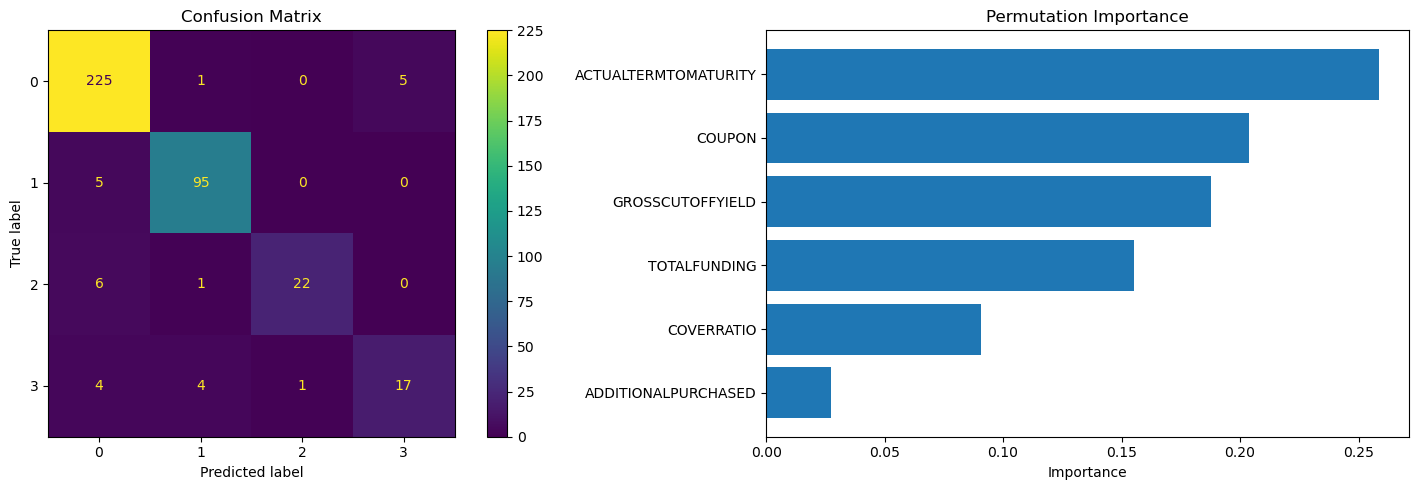

In [455]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to calculate VIF and cleaning
def vif(df):
    max_val = float('inf')
    while max_val > 5:
        vif_data = pd.DataFrame()
        X = df.select_dtypes(include=['float64', 'int64'])
        vif_data["feature"] = X.columns

        # calculating VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                           for i in range(len(X.columns))]
        max_val = max(vif_data["VIF"])
        for index, item in enumerate(vif_data['VIF']):
            if item >= max_val and max_val > 5:
                df = df.drop(vif_data.iloc[index, 0], axis=1)
    return df, vif_data

# Load dataset
df = pd.read_csv('file.csv', encoding='windows-1255')

# Remove date columns
date_columns = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).columns.str.contains('date', case=False, na=False)]
df = df.drop(columns=date_columns)

# Replace values in 'BONDS'
replacements = {
    'ממשלתית': 'GOV',
    'ממשלתית בריבית משתנה': 'GOV_VAR',
    'ממשלתית צמודה': 'GOV_INDEX',
    'ממשלתית קצרה': 'GOV_SHORT'
}
df['BONDS'] = df['BONDS'].map(replacements)

# Separate features and target for VIF calculation
df_features = df.drop(columns=['BONDS'])

# Calculate VIF and update features
df_features, vif_result = vif(df_features)
print("VIF Results After Dropping Features:\n", vif_result)

# Add the target column back to the dataset
df_scaled = pd.concat([df_features, df[['BONDS']]], axis=1)

# Separate features and target for modeling
X = df_scaled.drop(columns=['BONDS'])
y = df_scaled['BONDS']

# Define preprocessing for numerical and categorical data
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the model
knn = KNeighborsClassifier(n_neighbors=2)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))

print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Permutation Importance
perm_importance = permutation_importance(pipeline, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], cmap='viridis')
ax[0].set_title("Confusion Matrix")

ax[1].barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax[1].set_title("Permutation Importance")
ax[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

# T-SNE

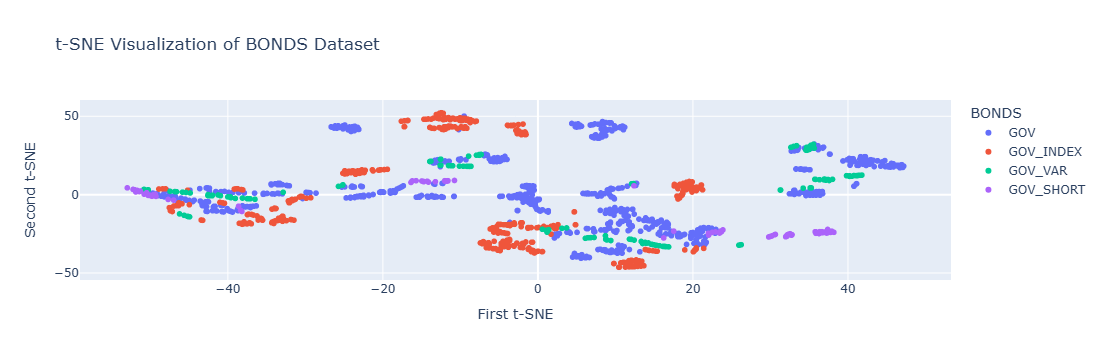

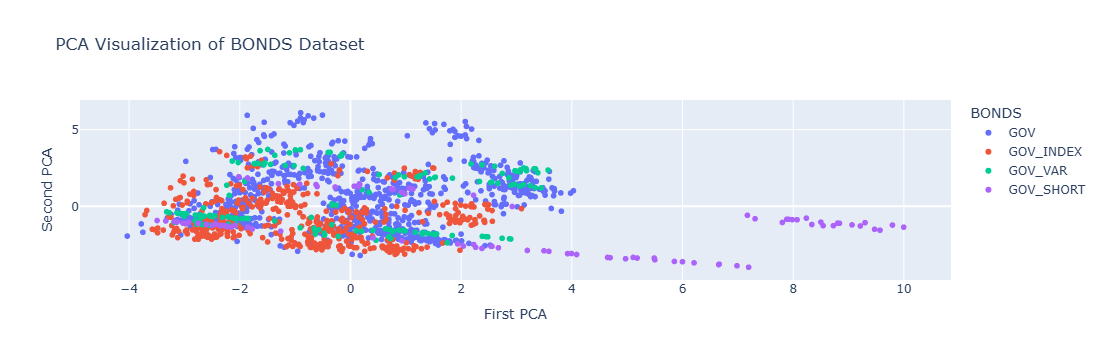

In [518]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import plotly.express as px

# Example dataset (replace df with your DataFrame)
data_scaled = df.copy()
X = data_scaled.drop(columns=['BONDS'])
y = data_scaled['BONDS']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define columns to scale
col_to_scale = X_train.columns

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_to_scale])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_train_scaled) - 1))
X_train_tsne = tsne.fit_transform(X_train_scaled)

# Create a DataFrame for t-SNE visualization
tsne_df = pd.DataFrame({
    "First t-SNE": X_train_tsne[:, 0],
    "Second t-SNE": X_train_tsne[:, 1],
    "BONDS": y_train.values
})

# Plot the t-SNE results
tsne_fig = px.scatter(
    tsne_df,
    x="First t-SNE",
    y="Second t-SNE",
    color="BONDS",
    title="t-SNE Visualization of BONDS Dataset"
)

tsne_fig.update_layout(
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)

# Apply PCA
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)

# Create a DataFrame for PCA visualization
pca_df = pd.DataFrame({
    "First PCA": X_train_pca[:, 0],
    "Second PCA": X_train_pca[:, 1],
    "BONDS": y_train.values
})

# Plot the PCA results
pca_fig = px.scatter(
    pca_df,
    x="First PCA",
    y="Second PCA",
    color="BONDS",
    title="PCA Visualization of BONDS Dataset"
)

pca_fig.update_layout(
    xaxis_title="First PCA",
    yaxis_title="Second PCA",
)

# Show both visualizations
tsne_fig.show()
pca_fig.show()

# Unsupervised Analysis

In [468]:
from sklearn.preprocessing import MinMaxScaler
new_data = data_scaled.drop(columns=['BONDS'])
scaler = MinMaxScaler()
unsupervise_data_scaled = pd.DataFrame(scaler.fit_transform(new_data), columns=new_data.columns)
unsupervise_data_scaled

,SERIES,ACTUALTERMTOMATURITY,ORIGINALTERMTOMATURITY,COUPON,OFFEREDQUANTITY,PURCHASEDQUANTITY,ADDITIONALPURCHASED,AVERAGEPRICE,CUTOFFPRICE,TOTALFUNDING,DEMANDEDAMOUNT,COVERRATIO,GROSSAVGYIELD,GROSSCUTOFFYIELD
0,0.670637,0.895765,1.000000,0.509091,0.052739,0.070287,1.000000,0.062549,0.064520,0.049275,0.014960,0.10,0.909244,0.907718
1,0.879293,0.322476,0.333333,0.727273,0.069928,0.090749,1.000000,0.380171,0.381474,0.090487,0.019315,0.10,0.835294,0.833893
2,0.893546,0.078176,0.100000,0.681818,0.060367,0.008778,0.724805,0.402795,0.404050,0.008945,0.001868,0.01,0.793277,0.791946
3,1.000000,0.140065,0.133333,0.836364,0.076794,0.096319,0.989851,0.421315,0.422532,0.099739,0.020500,0.10,0.810084,0.808725
4,0.822077,0.110749,0.133333,0.200000,0.063063,0.082577,1.000000,0.430742,0.431939,0.086233,0.017575,0.10,0.379832,0.379195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,0.187386,0.192182,0.266667,0.023636,0.022428,0.028030,0.975926,0.412332,0.413568,0.028782,0.005966,0.08,0.075630,0.075503
1924,0.339090,0.110749,0.133333,0.272727,0.120785,0.151290,1.000000,0.471110,0.472001,0.163677,0.120849,0.38,0.092437,0.092282
1925,0.373790,0.068404,0.066667,0.136364,0.120785,0.151290,1.000000,0.438061,0.439132,0.159016,0.173292,0.54,0.072269,0.072148
1926,0.361435,0.289902,0.300000,0.090909,0.120785,0.151290,1.000000,0.553510,0.554228,0.175299,0.169040,0.52,0.025210,0.025168


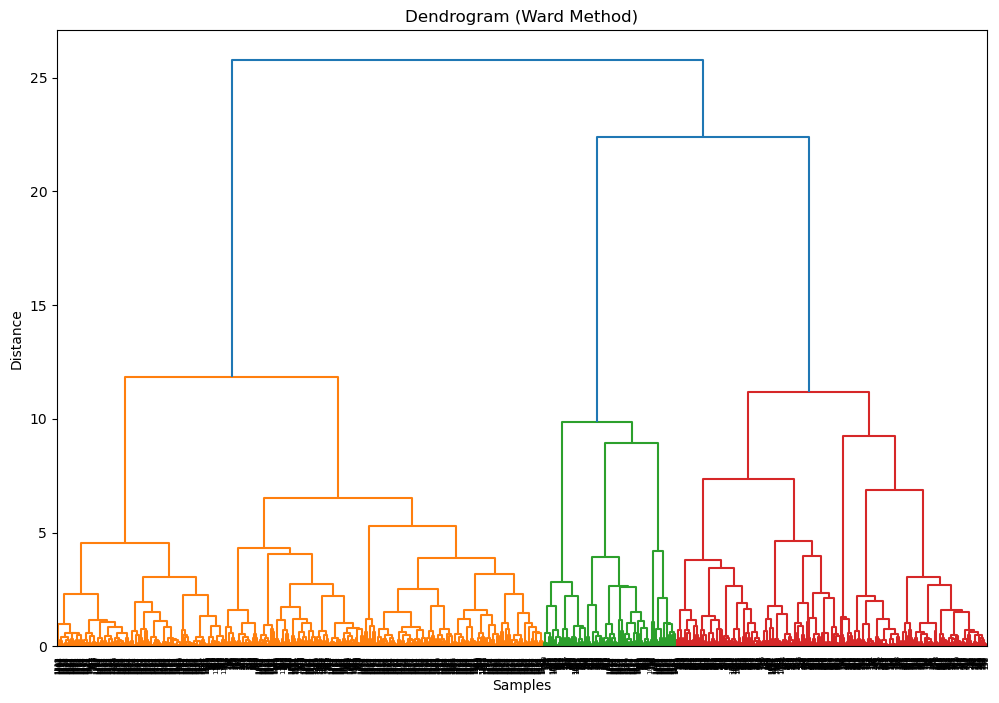

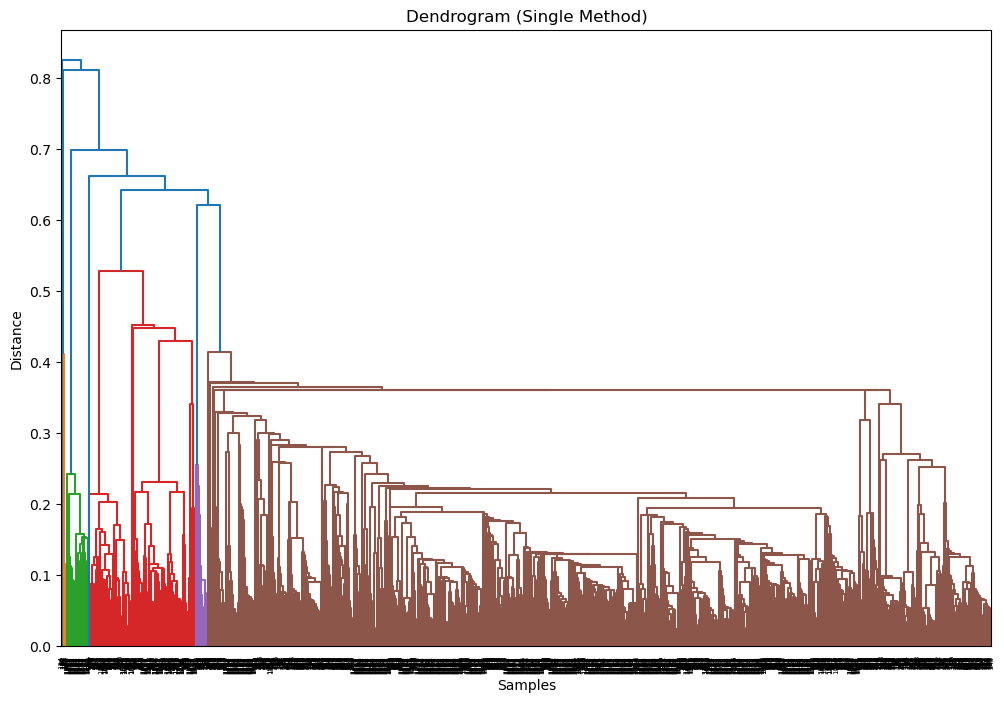

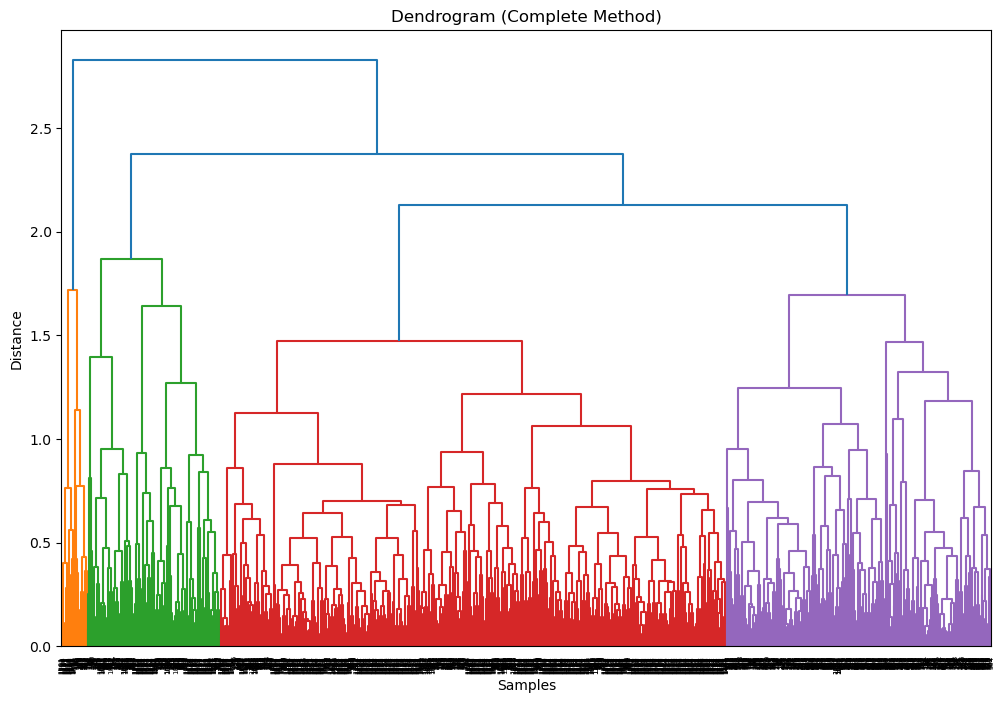

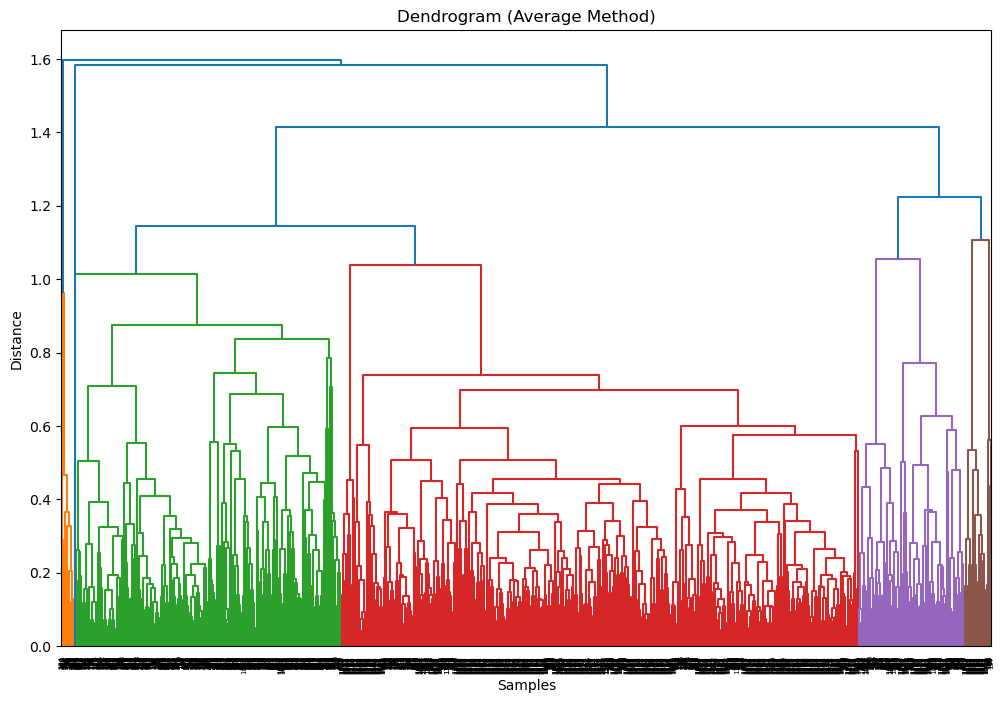

In [470]:
# Function to plot dendrograms

def plot_dendrogram(unsupervise_data, methods=['ward', 'single', 'complete', 'average']):
    for method in methods:
        plt.figure(figsize=(12, 8))
        dendrogram = sch.dendrogram(sch.linkage(unsupervise_data, method=method))
        plt.title(f'Dendrogram ({method.capitalize()} Method)')
        plt.xlabel('Samples')
        plt.ylabel('Distance')
        plt.show()


# Plot dendrograms with all methods
plot_dendrogram(unsupervise_data_scaled)

In [476]:
#Perform hierarchical clustering
hc_ward = sch.linkage(unsupervise_data_scaled, method="ward", metric="euclidean")

Text(0, 0.5, 'Variation in cluster distance')

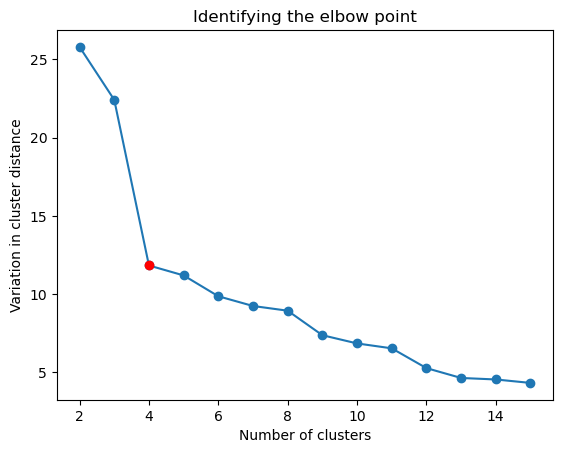

In [522]:
#Plot the elbow point
distances = hc_ward[-14:, 2]
num_clusters = np.arange(len(distances) + 1, 1, -1)
plt.plot(num_clusters, distances, marker='o')
plt.plot(4, hc_ward[-3,2], color='red', marker='o')
plt.title('Identifying the elbow point')
plt.xlabel('Number of clusters')
plt.ylabel('Variation in cluster distance')

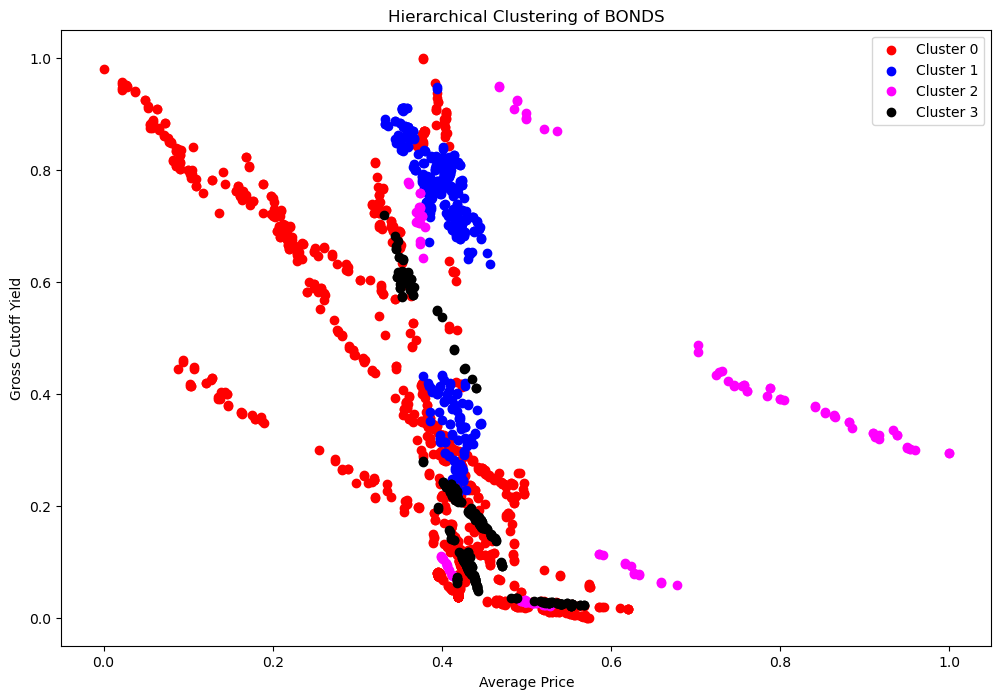

In [482]:
X_pc_hc = unsupervise_data_scaled.copy() # copy data
X_pc_hc['cluster'] = y_pc_hc #append cluster label form model prediction to new dataset
X_pc_hc.head()

# Visualization 2D
plt.figure(figsize = (12, 8))
plt.scatter(X_pc_hc.loc[X_pc_hc['cluster'] == 0, 'AVERAGEPRICE'], X_pc_hc.loc[X_pc_hc['cluster'] == 0, 'GROSSCUTOFFYIELD'], c = 'red', label = 'Cluster 0')
plt.scatter(X_pc_hc.loc[X_pc_hc['cluster'] == 1, 'AVERAGEPRICE'], X_pc_hc.loc[X_pc_hc['cluster'] == 1, 'GROSSCUTOFFYIELD'], c = 'blue', label = 'Cluster 1')
plt.scatter(X_pc_hc.loc[X_pc_hc['cluster'] == 2, 'AVERAGEPRICE'], X_pc_hc.loc[X_pc_hc['cluster'] == 2, 'GROSSCUTOFFYIELD'], c = 'magenta', label = 'Cluster 2')
plt.scatter(X_pc_hc.loc[X_pc_hc['cluster'] == 3, 'AVERAGEPRICE'], X_pc_hc.loc[X_pc_hc['cluster'] == 3, 'GROSSCUTOFFYIELD'], c = 'black', label = 'Cluster 3')
plt.title('Hierarchical Clustering of BONDS')
plt.xlabel('Average Price')
plt.ylabel('Gross Cutoff Yield')
plt.legend()
plt.show()

# K-Means

In [376]:
from sklearn.cluster import KMeans

In [484]:
wcss = []
cl_num=len(unsupervise_data_scaled.columns)
for i in range (1,cl_num):
    kmeans= KMeans(i)
    kmeans.fit(unsupervise_data_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

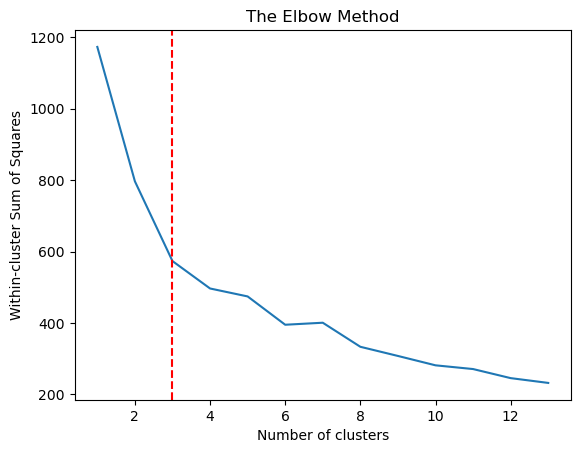

In [485]:
number_clusters = range(1,cl_num)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
optimal_k = 3
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')

In [488]:
k_means=KMeans(n_clusters=3,random_state=42)
k_means.fit(unsupervise_data)

KMeans(n_clusters=3, random_state=42)

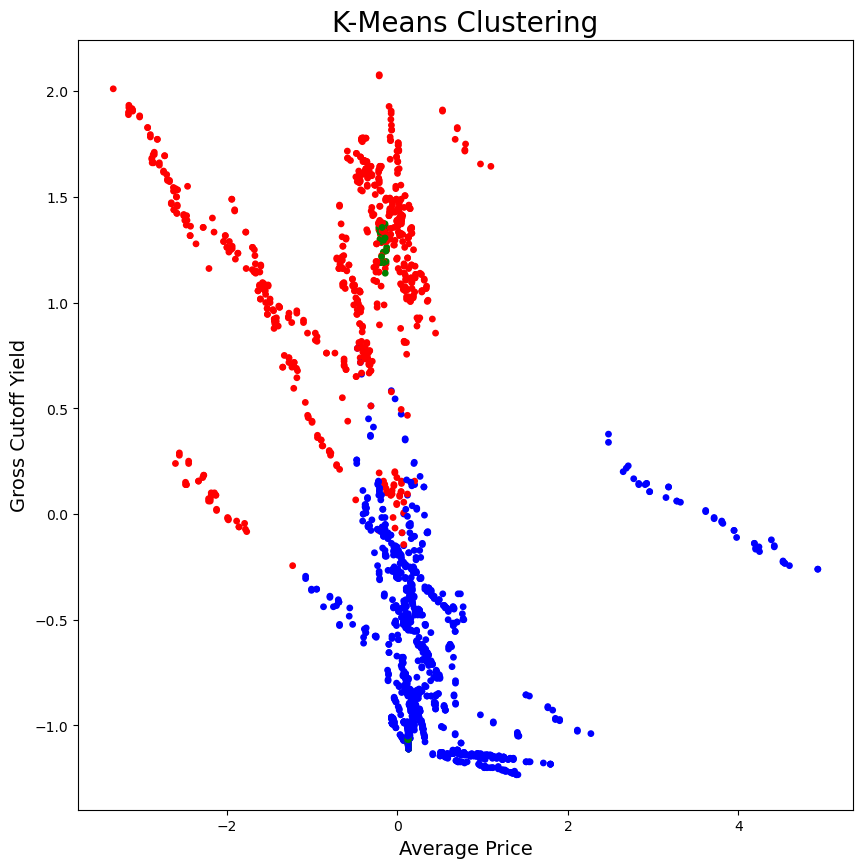

In [490]:
import matplotlib.colors
k_means_data = unsupervise_data_scaled.copy() 
k_means_data['KMeans_labels']=k_means.labels_

# Plotting resulting clusters
colors=['red','blue','green']
plt.figure(figsize=(10,10))
plt.scatter(unsupervise_data['AVERAGEPRICE'],unsupervise_data['GROSSCUTOFFYIELD'],c=k_means_data['KMeans_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('K-Means Clustering',fontsize=20)
plt.xlabel('Average Price',fontsize=14)
plt.ylabel('Gross Cutoff Yield',fontsize=14)
plt.show()

# DBSCAN

In [492]:
from sklearn.cluster import DBSCAN
dbscan_data = unsupervise_data_scaled.copy() # copy data
dbscan_data.head()
dbscan=DBSCAN()
dbscan_labels = dbscan.fit_predict(dbscan_data)
dbscan_data['DBSCAN_labels'] = dbscan_labels

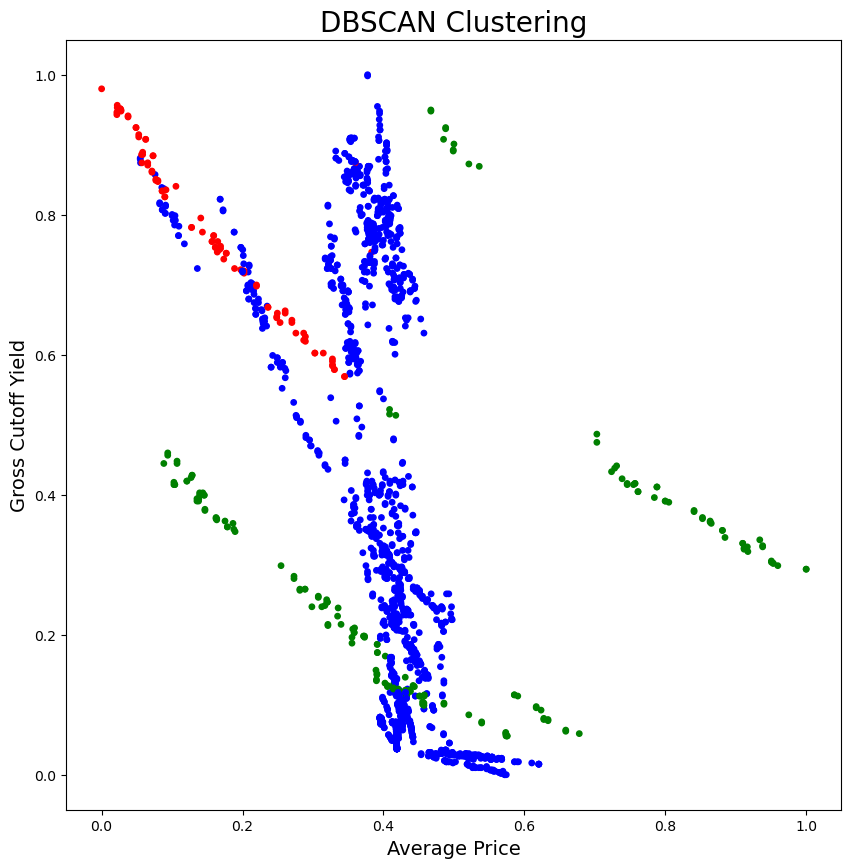

In [494]:
plt.figure(figsize=(10,10)) 
plt.scatter(dbscan_data['AVERAGEPRICE'],dbscan_data['GROSSCUTOFFYIELD'],c=dbscan_data['DBSCAN_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15) 
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Average Price',fontsize=14)
plt.ylabel('Gross Cutoff Yield',fontsize=14)
plt.show()

In [506]:
from sklearn.metrics import silhouette_score

kmeans_silhouette = silhouette_score(unsupervise_data_scaled, k_means.labels_)
hc_silhouette = silhouette_score(X_pc_hc, y_pc_hc)
if len(set(dbscan_labels)) > 1:  # Ensure more than one cluster exists
    dbscan_silhouette = silhouette_score(dbscan_data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
else:
    dbscan_silhouette = "Not Applicable (only noise or one cluster)"
    
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"Hierarchical Clustering Silhouette Score: {hc_silhouette}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

K-Means Silhouette Score: 0.3295325760134654
Hierarchical Clustering Silhouette Score: 0.42948020278493465
DBSCAN Silhouette Score: 0.5232128996971228


In [510]:
labeled_data = dbscan_data[dbscan.labels_ != -1]
labeled_labels = dbscan.labels_[dbscan.labels_ != -1]

In [512]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(labeled_data, labeled_labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [514]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred, average = 'macro'))

print("F1 Score:",metrics.f1_score(y_test, y_pred, average = 'weighted'))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# עבודה שוטפת עם המאגר בגיטהאב
### עדכון שינויים:

In [697]:
!git add "Data Mining Supervised & Unsupervised 2025.ipynb"
!git commit -m "Added Supervised models analysis 2025 notebook update"
!git push origin main
!git push --set-upstream origin main

[main 1fe4a41] Added Supervised models analysis 2025 notebook update
 1 file changed, 4443 insertions(+), 3192 deletions(-)


To https://github.com/DorNatan/data-mining-project-2025.git
   eda8929..1fe4a41  main -> main


branch 'main' set up to track 'origin/main'.


Everything up-to-date


In [626]:
!git add -u

In [629]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
